In [89]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
import matplotlib as mpl
from pathlib import Path
import yaml
from collections import Counter

from helpers.linkage import *
from helpers.afa import adaptive_filter
from helpers.visuals import add_cabinet_periods
import seaborn as sns
from helpers.networks import *
from helpers import style 
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.spatial.distance import euclidean
from scipy.stats import linregress

from fastdtw import fastdtw
import stumpy

cf = yaml.safe_load(Path('config.yml').read_text())

In [90]:
style.load_style(font='Roboto')

In [91]:
dists = pd.read_csv('/home/rb/Documents/Data/models/lda/full-postwar/dists-speech-bound-250',sep='\t')
data = pd.read_csv('/home/rb/Documents/Data/models/lda/full-postwar/data-speech-level-full.tsv',sep='\t')   
keys = pd.read_csv('/home/rb/Documents/Data/models/lda/full-postwar/keys-speech-bound-250',sep='\t')
labels = dict(zip(keys.index,keys.label))
labels_reverse =dict(zip(labels.values(),labels.keys()))

In [92]:
dists.index = pd.to_datetime(data.date,infer_datetime_format=True)
dists = {q:_.to_numpy() for q,_ in dists.groupby(dists.index.to_period('Q')) if len(_) > 100}
timestamps = sorted(list(set(dists.keys())))
del data

In [93]:
timeseries = []
edges = []
memberships = []

for c,date in tqdm(enumerate(dists)):
    theta = dists[date]
    prominence = {labels[c]:i for c,i in enumerate(theta.mean(axis=0))}

    theta = mutual_information(theta, topn=5)[0]
    g,comm,edge_df = get_network_from_mi_theta(mi_theta=theta,weight_threshold=0,node_text='labels',labels=labels)
    edge_df['p'] = date
    edges.append(edge_df)
    btw = dict(get_betweenness_values(g))
    deg = dict(get_degree_values(g))
    timeseries += [{"top":l,"date":date,"btw":btw[l],"deg":deg[l],"prom":prominence[l]} for l in btw.keys()]
    memberships.append(dict(zip([i['name'] for i in g.vs], comm.membership)))

timeseries = pd.DataFrame(timeseries)
edges = pd.concat(edges)

171it [01:41,  1.68it/s]


In [94]:
for col in ['btw','deg']:
    timeseries[col+'_rank'] = timeseries.groupby("date")[col].rank(method="dense", ascending=True)

ts_deg = timeseries.pivot(index='date',columns='top',values='deg').fillna(0.0).apply(zscore).apply(adaptive_filter,span=56)
ts_prom = timeseries.pivot(index='date',columns='top',values='prom').fillna(0.0).apply(zscore).apply(adaptive_filter,span=56)
ts_btw = timeseries.pivot(index='date',columns='top',values='btw').fillna(0.0).apply(zscore).apply(adaptive_filter,span=56)

In [14]:
top_ = ["municipal governance","inflation and employment","communism","united nations","coal and gas",
        "european community","agriculture","new guinea","deregulation","war reparations"]
len(top_)

10

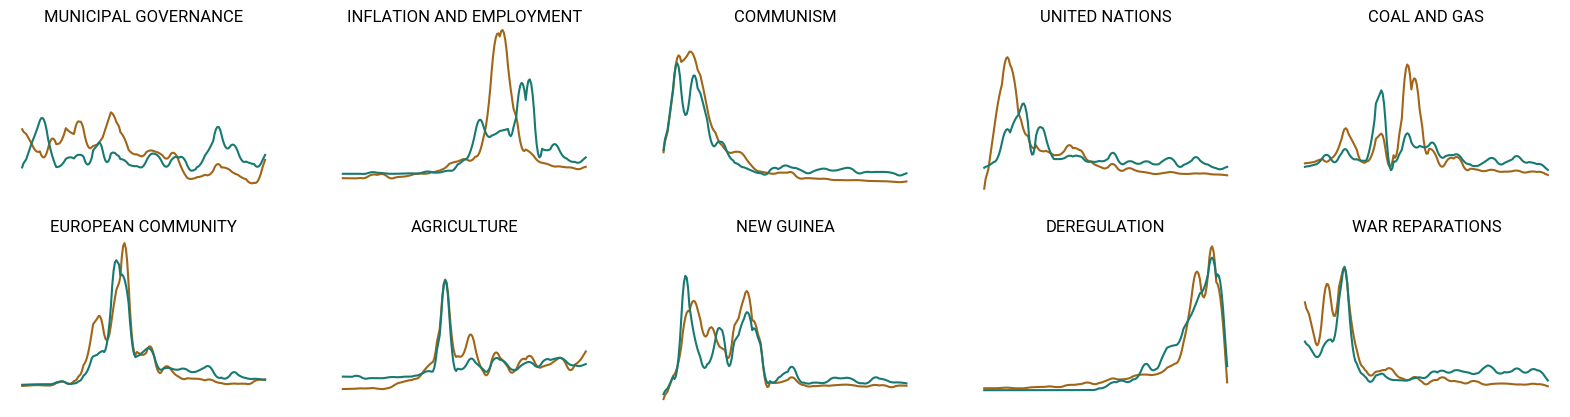

In [18]:
fig,ax = plt.subplots(2,5,figsize=(20,5),sharex=True,sharey=True)
pal = sns.color_palette('BrBG')

for c,topic in enumerate(top_):
    ax_ = ax.flatten()[c]
    ax_.plot(ts_prom.index.to_timestamp(),ts_prom[topic],color=pal[0])
    ax_.plot(ts_btw.index.to_timestamp(),ts_btw[topic],color=pal[-1])
    ax_.text(.5,1 ,topic.upper() , ha='center' ,transform = ax_.transAxes, fontsize = 12, alpha=1)
    ax_.axis('off')
    
# plt.subplots_adjust()
plt.savefig('figs/selection-topics.pdf')
plt.savefig('figs/selection-topics.png',dpi=350)
plt.show()
plt.close()

In [95]:
memberships = dict(zip(timestamps,memberships))

In [184]:
def plot_ts(ax,topic,save=False):
    d = timeseries[timeseries.top == topic]
    d = d.set_index('date').drop(columns='top').apply(adaptive_filter,span=48)
    x = d.index.to_timestamp()
    pcol, bcol = sns.color_palette('BrBG')[0],sns.color_palette('BrBG')[-1]
    ax.plot(x,d['prom'],label='Prominence',color=pcol)
    ax.spines[['top']].set_visible(False)
    ax2 = ax.twinx() 
    ax2.plot(x,d['btw'],label='Betweenness',color=bcol)
    ax2.spines[['top']].set_visible(False)
    ax2.set_ylim(0,15)
    ax.set_title(' '.join([w.capitalize() for w in topic.split(' ')]),fontsize=20)
    add_cabinet_periods(ax=ax2,text=False,min_time=1946,max_time=1991,color='lightgrey')
    if save == True:
        plt.savefig(f'figs/prom-btw-ts-{topic}.png',dpi=350)
        plt.show()

def plot_heatmap(ax=None,topic=None,min_year=10,filter_nonsem=True,figsize=(6,6),selected_labels=None):
    dfe = edges[edges.source == topic]
    dfe['p'] = dfe.p.dt.year
    dfe = dfe.groupby(['target','p']).mean().reset_index()
    dfe = dfe[dfe.groupby("target")['target'].transform('size') > min_year]
    if filter_nonsem:
        dfe = dfe[~dfe.target.str.contains('rhet|nonse|proc')]
    missing = pd.DataFrame([{"target":dfe.target.tolist()[0],"p":y,"weight":0} for y in range(1945,1992) if y not in dfe.p.unique()])
    dfe = pd.concat([dfe,missing])
    dfep = dfe.pivot(index='target',columns='p',values='weight').fillna(0.0)
    fo = dfep.gt(0).idxmax(axis=1).to_dict()
    dfep_bin = dfep.copy()
    dfep[dfep < 0] = 0
    dfep[dfep > 0] = 1
    
    for z,(i,r) in enumerate(dfep.iterrows()):
        X = r.index.tolist()
        Y = r.tolist()
        
        for c_,(xv,yv) in enumerate(zip(X,Y)):

            if yv > 0:
                # target_cluster = set([mbs.get(i) for t,mbs in memberships.items() if t.year == xv])
                # query_cluster = set([mbs.get('budget cuts') for t,mbs in memberships.items() if t.year == xv])
                # if any(c in target_cluster for c in query_cluster):
                #     col = sns.color_palette('BrBG')[-1]
                # else:
                #     col = sns.color_palette('BrBG')[0]
            
                ax.scatter(x = [xv],
                        y = [z],
                        s = 25 if yv > 0.0 else 0,
                        color = sns.color_palette('BrBG')[-1],
                        zorder=0,
                        linewidths=1,
                        edgecolor='white',
                        clip_on=False,
                        marker='s'
                        )
            
            if c_ < len(X) - 2 and yv > 0.0:

                if Y[c_+1] > 0.0:
                    next_val = X[c_+1]
                    ax.plot([xv,next_val],[z,z],color='gray',linewidth=.2,zorder=-1)
            
            if fo[i] == xv:
                ax.scatter(x=[xv],y=[z],s=100,color=sns.color_palette('BrBG')[-3],zorder=-2,clip_on=False,marker='s')

            if c_ < len(X) - 2 and yv > 0.0 and c_ > 0:
                if Y[c_+1] > 0.0 and Y[c_+2] > 0.0 and Y[c_-1] < 1.0:
                    ax.scatter(x=[xv],y=[z],s=50,color=sns.color_palette('BrBG')[-4],zorder=-2,clip_on=False,marker='s')

        ax.annotate(i,xy=(X[-1],z),ha='left',va='center',fontsize=9,clip_on=False)
    if selected_labels != None:
        ax.set_yticks(positions=range(len(dfep.index)),labels=selected_labels)
        
    ax.set_ylabel('Topics')
    ax.set_xlabel('Years')
    xtl = ['' if int(l.get_text()) not in range(1945,1991,5) else l.get_text() for l in ax.get_xticklabels()]
    ax.set_xticklabels(xtl)
    ax.spines[['top','left','right','bottom']].set_visible(False)
    ax.set_yticklabels([])
    ax.set_yticks([])
    return dfep

def heatmap_data(topic=None,min_year=10,filter_nonsem=True):
    dfe = edges[edges.source == topic]
    dfe['p'] = dfe.p.dt.year
    dfe = dfe.groupby(['target','p']).mean().reset_index()
    dfe = dfe[dfe.groupby("target")['target'].transform('size') > min_year]
    if filter_nonsem:
        dfe = dfe[~dfe.target.str.contains('rhet|nonse|proc')]
    missing = pd.DataFrame([{"target":dfe.target.tolist()[0],"p":y,"weight":0} for y in range(1945,1992) if y not in dfe.p.unique()])
    dfe = pd.concat([dfe,missing])
    dfep = dfe.pivot(index='target',columns='p',values='weight').fillna(0.0)
    dfep[dfep < 0] = 0
    dfep[dfep > 0] = 1
    return dfep

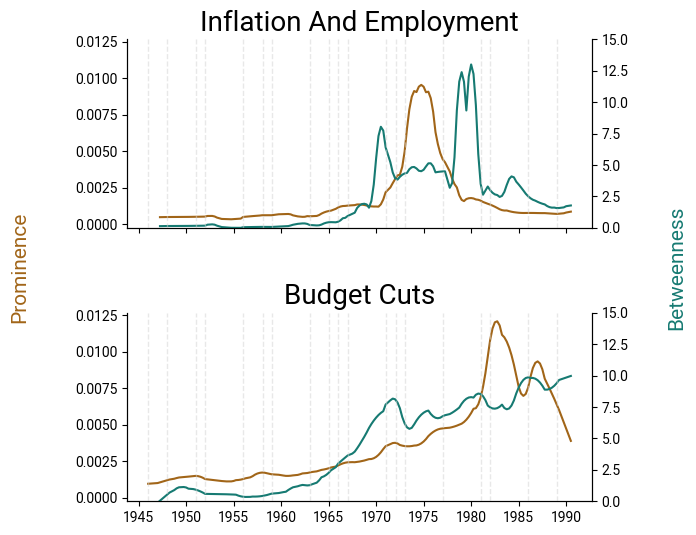

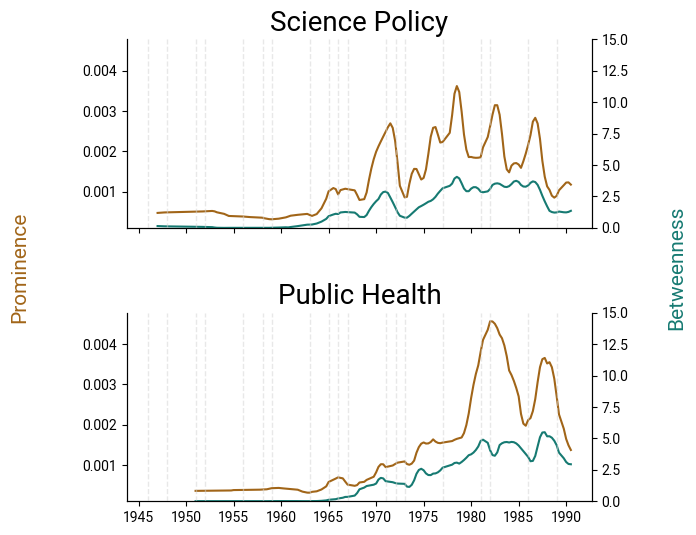

In [63]:
fig,ax = plt.subplots(2,1,figsize=(6,6),sharex=True,sharey=True)

plot_ts(topic='inflation and employment',ax=ax[0])
plot_ts(topic='budget cuts',ax=ax[1])

fig.text(-.07, 0.5, 'Prominence', va='center', rotation='vertical',color=sns.color_palette('BrBG')[0],fontsize=15)
fig.text(1.025, 0.5, 'Betweenness', va='center', rotation='vertical',color=sns.color_palette('BrBG')[-1],fontsize=15)


plt.subplots_adjust(hspace=.45)
plt.savefig('figs/prom-btw-ts-inflation-employment-budget-cuts.png',dpi=300,bbox_inches='tight')
plt.show()

fig,ax = plt.subplots(2,1,figsize=(6,6),sharex=True,sharey=True)

plot_ts(topic='science policy',ax=ax[0])
plot_ts(topic='public health',ax=ax[1])

fig.text(-.07, 0.5, 'Prominence', va='center', rotation='vertical',color=sns.color_palette('BrBG')[0],fontsize=15)
fig.text(1.025, 0.5, 'Betweenness', va='center', rotation='vertical',color=sns.color_palette('BrBG')[-1],fontsize=15)


plt.subplots_adjust(hspace=.45)
plt.savefig('figs/prom-btw-ts-science-policy-public-health.png',dpi=300,bbox_inches='tight')
plt.show()

/tmp/ipykernel_2725/1275601252.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfe['p'] = dfe.p.dt.year
/tmp/ipykernel_2725/1275601252.py:39: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfe = dfe.groupby(['target','p']).mean().reset_index()
/tmp/ipykernel_2725/1275601252.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xtl)


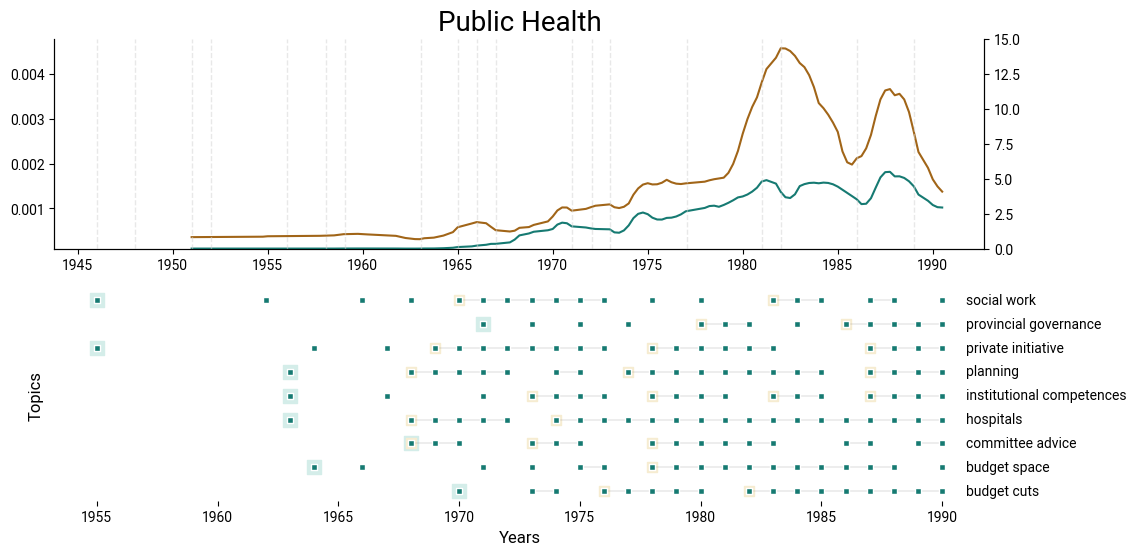

In [31]:
f,(a1,a2) = plt.subplots(2,1,figsize=(12,6),gridspec_kw={'height_ratios': [1, 1]})
plot_ts(topic='public health',ax=a1)
dfep = plot_heatmap(topic='public health',ax=a2)
plt.savefig('figs/ts-heatmap-public-health.png',dpi=500,bbox_inches='tight')
plt.show()

In [185]:
f,(a1,a2) = plt.subplots(2,1,figsize=(15,10),gridspec_kw={'height_ratios': [1, 5]})
plot_ts(topic='inflation and employment',ax=a1)

dfep = heatmap_data(topic='inflation and employment')
selected_labels = [dfep.index[i] if i in list(range(0,len(dfep),2)) else '' for i in range(len(dfep))]

dfep = plot_heatmap(topic='inflation and employment',ax=a2,selected_labels=selected_labels)
plt.savefig('figs/ts-heatmap-inflation-and-employment.png',dpi=500,bbox_inches='tight')
plt.show()

/tmp/ipykernel_265/4175622753.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfe['p'] = dfe.p.dt.year
/tmp/ipykernel_265/4175622753.py:87: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfe = dfe.groupby(['target','p']).mean().reset_index()
/tmp/ipykernel_265/4175622753.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

TypeError: Axis.set_ticks() missing 1 required positional argument: 'ticks'

In [102]:
dfep = heatmap_data('austerity')

/tmp/ipykernel_265/3577657482.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfe['p'] = dfe.p.dt.year
/tmp/ipykernel_265/3577657482.py:85: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfe = dfe.groupby(['target','p']).mean().reset_index()


In [170]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

def create_animated_line_plot(x_values, y_values_list, speed, output_filename, line_colors=None,topic='',figsize=(6,3)):
    fig, ax = plt.subplots(figsize=figsize)
    lines = [ax.plot([], [], lw=2, color=color)[0] for color in line_colors] if line_colors else [ax.plot([], [], lw=2)[0]]
    # ax.set_xlim(min(x_values), max(x_values))
    ax.set_xlim(x_values[0],x_values[-1])
    miny = np.min([np.min(v) for v in y_values_list])
    maxy = np.max([np.max(v) for v in y_values_list])

    ax.set_ylim(miny,maxy)
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.text(.5,1 ,topic.upper() , ha='center' ,transform = ax.transAxes, fontsize = 12, alpha=1)
    # ax.text(.5,.8 ,'Prominence  ', ha='right' ,transform = ax.transAxes, fontsize = 12, alpha=1,color=line_colors[0])
    # ax.text(.5,.8 ,'  Betweenness', ha='left' ,transform = ax.transAxes, fontsize = 12, alpha=1,color=line_colors[1])
    
    def update(frame):
        for i, line in enumerate(lines):
            x = x_values[:frame]
            y = y_values_list[i][:frame]
            line.set_data(x, y)
        
        return lines
    ax.spines[['top','left','right']].set_visible(False)
    animation = FuncAnimation(fig, update, frames=len(x_values), interval=speed, blit=True)
    animation.save(output_filename, writer='pillow')
    
    plt.close(fig)

def plot_anim(topic,speed):
    x = ts_prom.index.to_timestamp().tolist()
    y = zscore(ts_prom[topic]).to_numpy()
    y2 = zscore(ts_btw[topic]).to_numpy()

    col1, col2 = sns.color_palette('BrBG')[0],sns.color_palette('BrBG')[-1]
    create_animated_line_plot(x, [y,y2], speed, f'/home/rb/Desktop/{topic}.gif',[col1,col2],topic)

In [153]:
top_ = ["inflation and employment","communism","united nations","coal and gas",
        "european community","agriculture","new guinea","deregulation"]
len(top_)

8

In [75]:
for top in top_:
    plot_anim(top,speed=300)

In [167]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

def animate_points(series_x_values, series_y_values, colors=None, labels=None, ylim=None, filepath=None, interval=200, figsize=(8,3),frames=10):
    fig, ax = plt.subplots(figsize=figsize)
    scatter_plots = []

    for i, (x_values, y_values) in enumerate(zip(series_x_values, series_y_values)):
        scatter_plot = ax.scatter([], [], color='teal',s=10,marker='s')
        scatter_plots.append(scatter_plot)

    def update(frame):
        for scatter_plot, x_values, y_values in zip(scatter_plots, series_x_values, series_y_values):
            valid_indices = [i for i, value in enumerate(y_values[:frame+1]) if value is not None]
            valid_x_values = [x_values[i] for i in valid_indices]
            valid_y_values = [y_values[i] for i in valid_indices]
            scatter_plot.set_offsets(np.column_stack((valid_x_values, valid_y_values)))
        return scatter_plots

    max_x = max([max(x_values) for x_values in series_x_values])
    min_x = min([min(x_values) for x_values in series_x_values])

    ax.set_ylim(-1, len(series_y_values) + 1)

    ax.set_xlim(min_x, max_x)
    ax.set_yticks(list(range(len(series_x_values))),labels,fontsize=12)
    ax.yaxis.tick_right()
    ax.spines[['right', 'top','left']].set_visible(False)
    ax.yaxis.grid(color='lightgrey',linewidth=.25, zorder = 0) # horizontal lines
    ax.xaxis.grid(color='lightgrey',linewidth=.25, zorder = 0) # horizontal lines

    fig.tight_layout()
    ani = animation.FuncAnimation(fig, update, frames=frames, interval=interval, blit=True) #max([len(x_values) for x_values in series_x_values])

    if filepath:
        ani.save(filepath, writer='pillow', fps=int(1000 / interval))
    else:
        plt.show()

    plt.close(fig)


In [149]:
x_ = list(dfep.columns)
xv = [x_ for i in range(len(dfep))]

yv = []

for i in range(len(dfep)):
    y_ = dfep.iloc[i,:].tolist()
    y_ = [i if v == 1 else None for v in y_]
    yv.append(y_)

In [173]:
topic='austerity'
x = ts_prom.index.to_timestamp().tolist()
y = zscore(ts_prom[topic]).to_numpy()
y2 = zscore(ts_btw[topic]).to_numpy()

col1, col2 = sns.color_palette('BrBG')[0],sns.color_palette('BrBG')[-1]
create_animated_line_plot(x, [y,y2], 200, f'/home/rb/Desktop/{topic}.gif',[col1,col2],topic, figsize=(12,2))

dfep = heatmap_data(topic)

/tmp/ipykernel_265/3577657482.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfe['p'] = dfe.p.dt.year
/tmp/ipykernel_265/3577657482.py:85: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfe = dfe.groupby(['target','p']).mean().reset_index()


In [175]:
animate_points(series_x_values=xv,
               series_y_values=yv,
               filepath='/home/rb/Desktop/austerity-hm.gif',
               interval=200,
               labels=dfep.index.tolist(),
               frames=len(x),
               figsize=(12,3))

In [177]:
ax

NameError: name 'ax' is not defined